# Federated ML
## Contents
1. Introduction
2. Reading an image from the dataset
3. Loading Images and Labels
4. Splitting training and testing data
5. Creating clients
6. Batching clients' and test data
7. Creating an MLP model
8. Optimizer, Loss function and Metrics to compile the model
9. Utility functions for the Federated Averaging
10. Model test function
11. Federated Averaging Algorithm

## Introduction
In this notebook, we have implemented i working Federated ML model. The goal is to simulate packet losses in communication between the server and the clients in the Federated Averaging Algorithm. The function once implemented will be added to the algorithm near the TODO's in the code.

Reading an image from the dataset

Text(0.5, 1.0, 'Image')

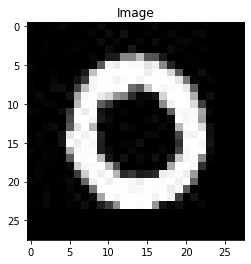

In [115]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread("datasets/numbers/trainingSet/0/img_1.jpg")
plt.imshow(image)
plt.title("Image")

Loading Images and Labels

In [116]:
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
dir_path = "datasets/numbers/trainingSet/"
images = list()
labels = list()
for number in range(0, 10):
    folder = dir_path + str(number)
    for image_file in os.listdir(folder):
        image_gray = cv2.imread(os.path.join(folder, image_file), cv2.IMREAD_GRAYSCALE)
        image = np.array(image_gray).flatten()
        images.append(image/255)
        labels.append(number)
    print("[INFO] Processed {}/{}".format(number + 1, 10))
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

[INFO] Processed 1/10
[INFO] Processed 2/10
[INFO] Processed 3/10
[INFO] Processed 4/10
[INFO] Processed 5/10
[INFO] Processed 6/10
[INFO] Processed 7/10
[INFO] Processed 8/10
[INFO] Processed 9/10
[INFO] Processed 10/10


Splitting training and testing data

In [117]:
from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.1, random_state=42)

Creating clients

In [118]:
import random
num_clients = 10
client_names = ["client_{}".format(i + 1) for i in range(num_clients)]
data = list(zip(images, labels))
random.shuffle(data)
size = len(data)//num_clients
data_shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
clients = {client_names[i]: data_shards[i] for i in range(num_clients)}

Batching clients' and test data

In [119]:
import tensorflow as tf
batch_size = 32
clients_batched = dict()
for (client_name, data_shard) in clients.items():
    data, labels = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(labels)))
    clients_batched[client_name] = dataset.shuffle(len(labels)).batch(batch_size)
test_batched = tf.data.Dataset.from_tensor_slices((images_test, labels_test)).batch(len(labels_test))

Creating the Multi Layer Perception (MLP) model

In [120]:
from keras.models import Sequential
from keras.layers import Dense, Activation
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

Optimizer, Loss function and Metrics to compile the model

In [121]:
from keras.optimizers import SGD
lr = 0.01 
comms_round = 100
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, decay=lr/comms_round, momentum=0.9)

c:\Users\mdnaj\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Utility functions for the Federated Averaging

In [122]:
def weight_scaling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
    return avg_grad

Functions to fetch and set shape of model weights

In [123]:
def get_shape(weights):
    shapes = [i.shape for i in weights]
    return shapes

def flatten_model_weights(weights):
    flattened_weights = np.concatenate([i.flatten() for i in weights])
    return flattened_weights

def restore_model_shape(flattened_weights, shapes):
    weights = []
    index = 0
    for shape in shapes:
        size = np.product(shape)
        arr = np.array(flattened_weights[index : index + size])
        weights.append(arr.reshape(shape))
        index += size
    return weights

Modulation and Demodulation Functions for Communication

In [124]:
from bitstring import BitArray
import random

def modulation(weights):
    weights = flatten_model_weights(weights)
    packets = []
    for i in range(len(weights)):
        packet = BitArray(float=weights[i], length=32)
        packets.append(packet.bin)
    return packets

def demodulation(packets, packet_loss_prob, model_shape):
    weights = packets
    for i in range(len(packets)):
        weight = BitArray(bin=packets[i])
        if random.random() < packet_loss_prob:
            weights[i] = 0
        else:
            weights[i] = weight.float
    return restore_model_shape(weights, model_shape)

Model test function

In [125]:
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import accuracy_score
def test_model(X_test, Y_test,  model, comm_round):
    cce = CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round+1, acc, loss))
    return acc, loss

Federated Averaging Algorithm

In [126]:
from keras import backend as K
def fedML(packet_loss_prob):
    smlp_global = SimpleMLP()
    global_model = smlp_global.build(784, 10)
    model_shape = get_shape(global_model.get_weights())
    accuracy = []
    for comm_round in range(comms_round):
        global_weights = global_model.get_weights()
        scaled_local_weight_list = list()
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        for client in client_names:
            smlp_local = SimpleMLP()
            local_model = smlp_local.build(784, 10)
            local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
            local_model.set_weights(global_weights)
            local_model.fit(clients_batched[client], epochs=1, verbose=0)
            scaling_factor = weight_scaling_factor(clients_batched, client)
            scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
            packets = modulation(scaled_weights)
            new_weights = demodulation(packets, packet_loss_prob, model_shape)
            scaled_local_weight_list.append(new_weights)
            K.clear_session()
        average_weights = sum_scaled_weights(scaled_local_weight_list)
        global_model.set_weights(average_weights)
        for(X_test, Y_test) in test_batched:
            global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
            accuracy.append(global_acc)
    return accuracy

In [127]:
errors = [0, 0.01, 0.05, 0.1]
accuracies = []
for error in errors:
    accuracies.append(fedML(error))
    print("{}".format(error))

132/132 [==============================] - 1s 3ms/step
comm_round: 1 | global_acc: 88.786% | global_loss: 1.6624020338058472
132/132 [==============================] - 0s 3ms/step
comm_round: 2 | global_acc: 91.214% | global_loss: 1.6090692281723022
132/132 [==============================] - 0s 3ms/step
comm_round: 3 | global_acc: 92.286% | global_loss: 1.5902550220489502
132/132 [==============================] - 0s 3ms/step
comm_round: 4 | global_acc: 93.476% | global_loss: 1.5772944688796997
132/132 [==============================] - 0s 3ms/step
comm_round: 5 | global_acc: 93.690% | global_loss: 1.56877863407135
132/132 [==============================] - 1s 5ms/step
comm_round: 6 | global_acc: 94.095% | global_loss: 1.5603489875793457
132/132 [==============================] - 1s 4ms/step
comm_round: 7 | global_acc: 94.571% | global_loss: 1.5549336671829224
132/132 [==============================] - 1s 4ms/step
comm_round: 8 | global_acc: 94.929% | global_loss: 1.5499669313430786
13

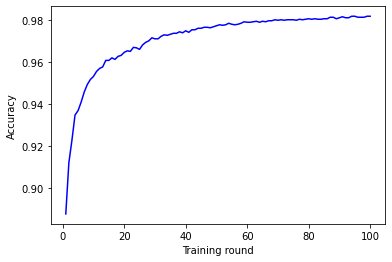

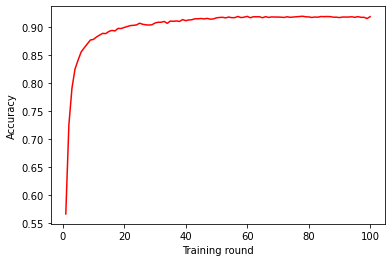

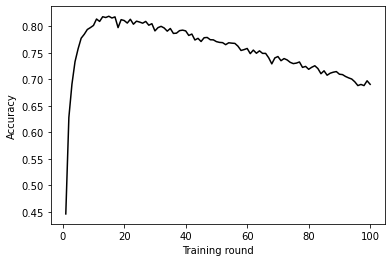

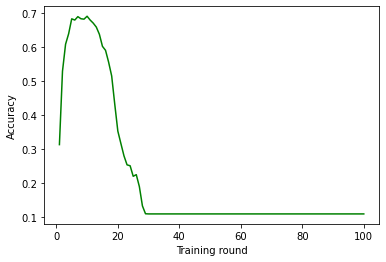

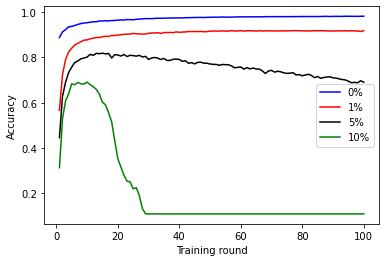

In [128]:
x_axis = []
for i in range(100):
    x_axis.append(i+1)
plt.plot(x_axis, accuracies[0], color="blue")
plt.xlabel("Training round")
plt.ylabel("Accuracy")
plt.show()
plt.plot(x_axis, accuracies[1], color="red")
plt.xlabel("Training round")
plt.ylabel("Accuracy")
plt.show()
plt.plot(x_axis, accuracies[2], color="black")
plt.xlabel("Training round")
plt.ylabel("Accuracy")
plt.show()
plt.plot(x_axis, accuracies[3], color="green")
plt.xlabel("Training round")
plt.ylabel("Accuracy")
plt.show()
plt.plot(x_axis, accuracies[0], color="blue")
plt.plot(x_axis, accuracies[1], color="red")
plt.plot(x_axis, accuracies[2], color="black")
plt.plot(x_axis, accuracies[3], color="green")
plt.legend(["0%","1%","5%","10%"])
plt.xlabel("Training round")
plt.ylabel("Accuracy")
plt.show()